# ARIMA/SARIMA Modeling
- ARIMA/SARIMA
- Holt Winter's

### Import Packages

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
from pmdarima import auto_arima

### Load Functions

In [67]:
import matplotlib.pyplot as plt

def plot_multiple_series(xvalue, yvalues, labels, title, xlabel, ylabel, alpha=None):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        if alpha is not None:
            plt.plot(xvalue[i], yvalues[i], label=labels[i], alpha=alpha[i])
        else:
            plt.plot(xvalue[i], yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [68]:
#Create a function for line time series
def line_series(x,y,title,xlabel,ylabel,grid=False):
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()

In [69]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [70]:
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [71]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [72]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
#Create list of months
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

def create_monthly_data(df,value_column,incrementing_month):

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = (i) // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

### Load Data

In [73]:
# components removed
seasonal_decomposition_components = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/components_removed_sales_data.csv')
seasonal_decomposition_components.drop(columns='Unnamed: 0',inplace=True)

# import original data
data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/sales_data.csv')

# import irregularties removed data
sales_data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/irregularities_deseasonlised_sales_data.csv')
sales_data.drop(columns='Unnamed: 0',inplace=True)
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data['original_cars_sold'] = data['total_cars_sold']

# import deseasonlised sales data
sales_data_deseasonlised_removed = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/irregularities_deseasonlised_sales_data.csv')
sales_data_deseasonlised_removed.drop(columns='Unnamed: 0',inplace=True)

## Number of Cars Sold Modeling

#### Split into Train/Test Model
Chapter 2 looked at all of the data with new data past the date of 2023-12-01 will be used as the test data. However with more automated attempts to forecast using the train/test split of data method will be necessary.

Chapter 2 displayed a clear cycle that took place every 12 years, the data will be split using that knowledge.

- Training data : 2002-01-01 - 2013-12-01
- Test data : 2014-01-01 - 2023-12-01

In [74]:
# look at sales data with irregularities and deseasonlised data
sales_data

,date,irregularities_removed_cars_sold,seasonal_values,irregularities_deseasonlised_cars_sold,original_cars_sold
0,2002-01-01,81033,-8178.636364,89211.636364,81033
1,2002-02-01,78502,-11696.318182,90198.318182,78502
2,2002-03-01,93019,7778.045455,85240.954545,93019
3,2002-04-01,96269,6449.409091,89819.590909,96269
4,2002-05-01,97936,5842.818182,92093.181818,97936
...,...,...,...,...,...
259,2023-08-01,78601,6265.454545,72335.545455,78601
260,2023-09-01,69278,1952.545455,67325.454545,69278
261,2023-10-01,69248,418.954545,68829.045455,69248
262,2023-11-01,64980,-9552.954545,74532.954545,64980


In [75]:
# method 1 - split data from 2002 to 2014
split_date = '2014-01-01'

train_data = sales_data[sales_data['date'] < split_date]
test_data = sales_data[sales_data['date']>= split_date]

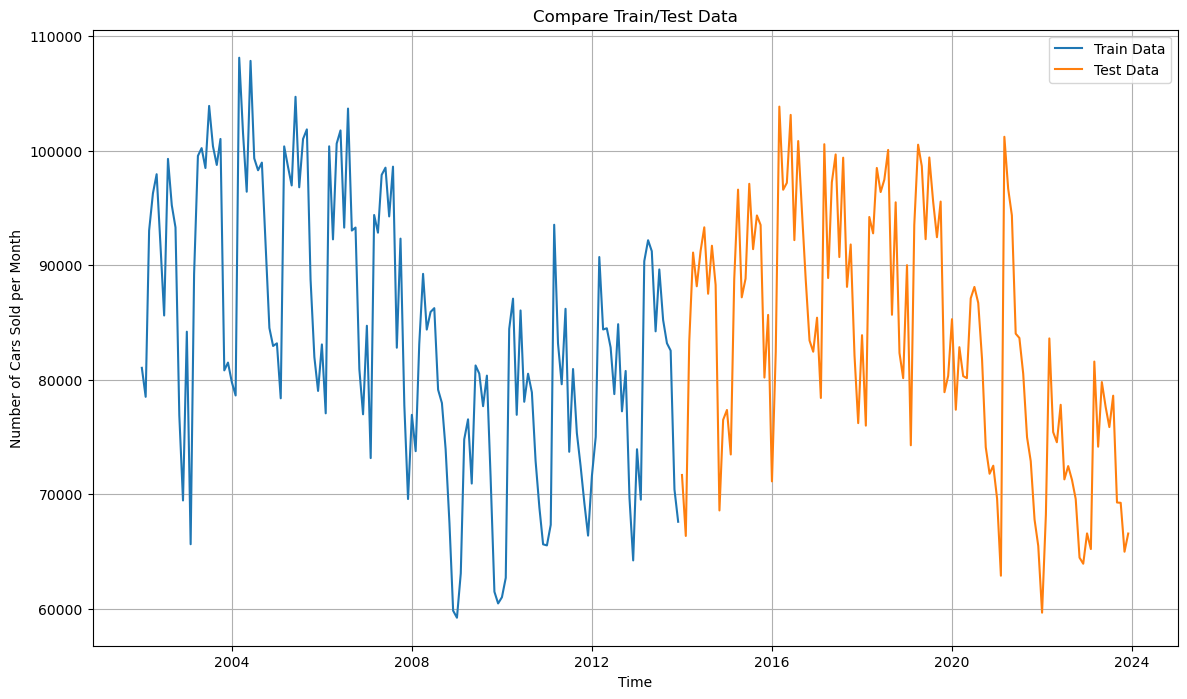

In [76]:
# plot multiple series
plot_multiple_series([pd.to_datetime(train_data['date']),pd.to_datetime(test_data['date'])],
                     [train_data['irregularities_removed_cars_sold'],test_data['irregularities_removed_cars_sold']],
                     ['Train Data','Test Data'],'Compare Train/Test Data',
                     'Time','Number of Cars Sold per Month')

### SARIMA/ARIMA Model
SARIMA is made up of 
- Seasonal (S)
- Autoregressive (AR)
- Integrated (I)
- Moving Average (MA)

Combining observations of ACF/PACF plots to find optimised p/q values. 

#### ARIMA Model
Using the deseasonlised data, then adding it seasonality after the forecasting has taken place, allows a comparison of this and the SARIMA model using the train/test data.

In [77]:
# select the series that will be used for arima (p,d,q) data
arima_data = train_data['irregularities_removed_cars_sold']

In [78]:
# use the ADF test to determine whether the data is stationary or not
adf_test(arima_data)

ADF Statistic:  -1.2158000035580143
P-Value:  0.6667622882435609
Critical Value: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


The p value does not represent a stationary time series, this reflects a time series which will have a change in values based on when the time of data was used. Difference the data.

In [79]:
# look at the first differenced data
arima_first_difference = arima_data.diff()

# print out the result of the first difference to check for stationarity
adf_test(arima_first_difference.dropna())

ADF Statistic:  -2.6249967633415463
P-Value:  0.08794020825702376
Critical Value: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


The ADF statistic is at the 10% threshold of signifigance for evidence suggesting that it is likely the data is stationary. To improve this further take the second difference.

In [80]:
# look at second differenced data
arima_second_difference = arima_first_difference.diff()

# print the result of the second difference for stationarity 
adf_test(arima_second_difference.dropna())

ADF Statistic:  -12.100470710984384
P-Value:  2.0239033917174405e-22
Critical Value: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


The ADF statistic is far greater than the 1% threshold so when there is two differencing there is strong confidence that the series is stationary.

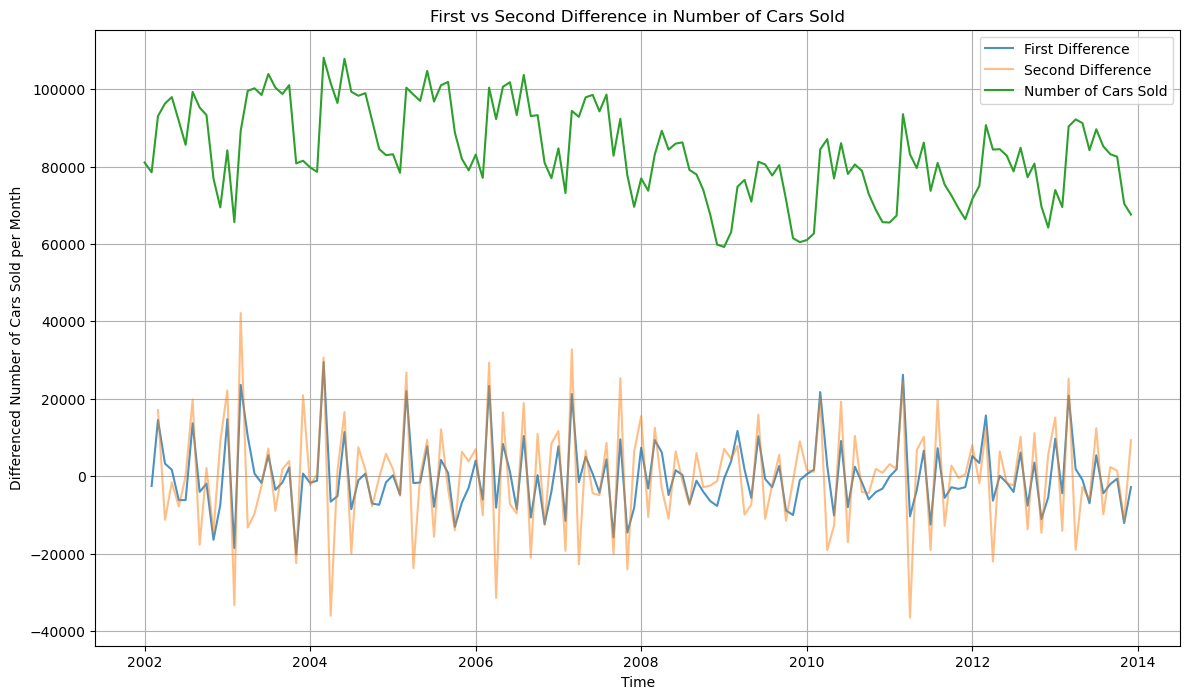

In [81]:
# plot the difference between the first and second difference
plot_multiple_series([train_data['date'],train_data['date'],train_data['date']],[arima_first_difference,arima_second_difference,train_data['irregularities_removed_cars_sold']],
                     ['First Difference','Second Difference','Number of Cars Sold'],
                     'First vs Second Difference in Number of Cars Sold','Time','Differenced Number of Cars Sold per Month',[0.8,0.5,1])

The second difference with the large oscillations is the stationary data, this reflects very closely to white noise where at any point in time there will be no dependence on the variable time for a given result.

##### Autoregressive (AR) - p
Look at the PACF plot to find the autoregressive (p) component of the ARIMA model

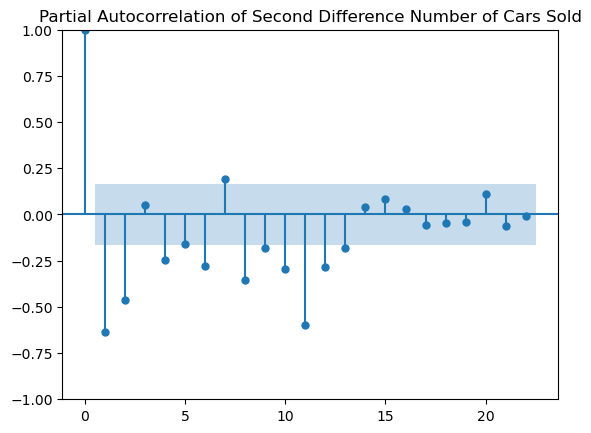

In [95]:
# pacf plot
arima_pacf_plot = plot_pacf(arima_second_difference.dropna(),title='Partial Autocorrelation of Second Difference Number of Cars Sold')

In [98]:
# The lags seem to be taking place at 1,2 however there is another large value at 11 lags.This means that there might be a seasonality at this lag.
# p values
arima_p_order = [1,2]

##### Moving Average (MA) - q

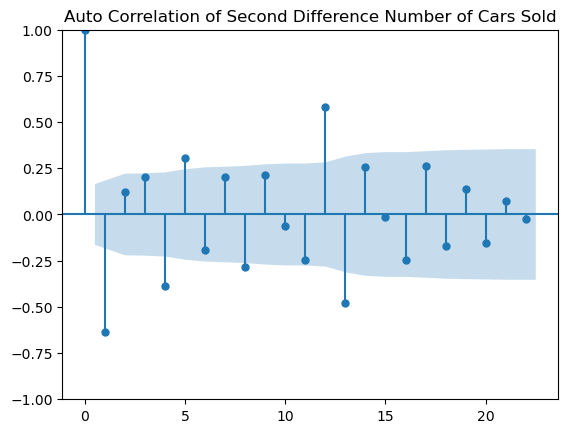

In [97]:
arima_acf = plot_acf(arima_second_difference.dropna(),title='Autocorrelation of Second Difference Number of Cars Sold')

In [99]:
# lags exist at 1 and 4
arima_q_order = [1,4]

In [100]:
# find the best order for prediction
evaluate_time_series_models(arima_second_difference,arima_p_order,arima_q_order,arima_d_order)

,Model,Order,AIC,BIC
7,ARMA,"(2, 0, 4)",2978.409059,3002.167565
5,ARMA,"(1, 0, 4)",2985.492655,3006.281348
4,ARMA,"(1, 0, 1)",2990.821616,3002.700869
2,MA,"(0, 0, 1)",2998.246095,3007.155534
13,ARIMA,"(2, 1, 4)",2999.589094,3020.329006
3,MA,"(0, 0, 4)",3001.564610,3019.383489
6,ARMA,"(2, 0, 1)",3015.774188,3030.623255
1,AR,"(2, 0, 0)",3017.724566,3029.603819
12,ARIMA,"(2, 1, 1)",3025.123906,3036.975285
9,ARIMA,"(1, 1, 4)",3037.944040,3055.721108


In [ ]:
evaluate_time_series_models(train_data,)

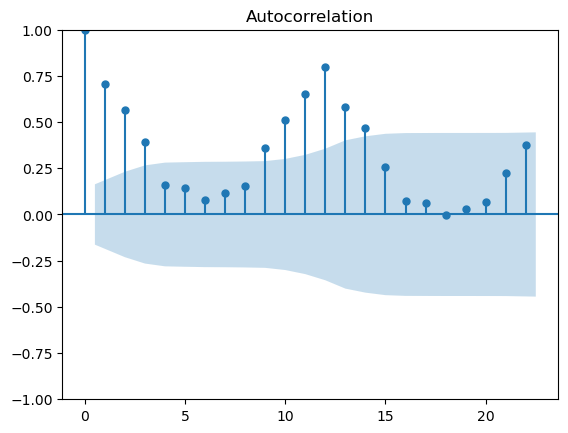

In [102]:
non_differenced = plot_acf(train_data['irregularities_removed_cars_sold'])

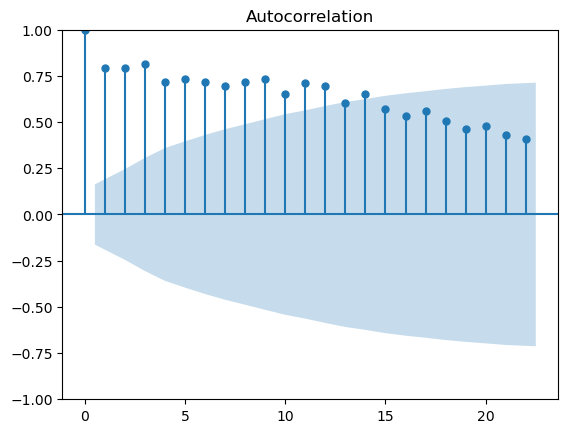

In [103]:
non_differenced_deseasonlised = plot_acf(train_data['irregularities_deseasonlised_cars_sold'])